[![image.png](https://i.postimg.cc/RhYr7Yv1/image.png)](https://postimg.cc/Zv6DZVB0)

<div style="padding:20px 30px 30px; 
            color:#004346;
            font-size:40px;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400"> 
<p style="font-weight: bold; text-align: center;">Прогнозирование температуры звезды</p>


</div>

<div style="padding:0px 40px 30px; 
            color:#004346;
            font-size:110%;
            display:fill;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:450;"> 
    
__Заказчик:__ обсерватория «Небо на ладони».
    
__Постановка задачи:__ разработка метода определения температуры на поверхности обнаруженных звёзд с использованием нейросетевого подхода.
    
__Описание задачи:__ необходимо создать модель нейронной сети, способную определять температуру на поверхности обнаруженных звёзд на основе доступных данных. Для этого требуется подготовить набор данных, содержащий информацию о различных характеристиках звёзд и соответствующие им измеренные значения температуры. Затем следует обучить нейросеть на этом наборе данных, чтобы она могла выявить закономерности и установить связь между входными параметрами и целевыми значениями температуры.    

__Оценка результата:__ В данной задаче мы можем использовать метрику RMSE (Root Mean Square Error) для оценки качества модели. Цель состоит в том, чтобы минимизировать значение RMSE и добиться, чтобы оно не превышало 4500. RMSE представляет собой квадратный корень из среднеквадратичной ошибки между прогнозируемыми и фактическими значениями температуры.
    
__Описание данных:__
    
В базе обсерватории есть данные о 240 звёзд:
    
- `Luminosity(L/Lo)` - Относительная светимость — светимость звезды относительно Солнца.
- `Radius(R/Ro)` - Относительный радиус — радиус звезды относительно радиуса Солнца.
- `Absolute magnitude(Mv)` — Абсолютная звёздная величина — физическая величина, характеризующая блеск звезды.
- `Star color` — Звёздный цвет (white, red, blue, yellow, yellow-orange и др.) — цвет звезды, который определяют на основе спектрального анализа.
- `Star type` — Тип звезды:
    | Тип звезды | Номер, соответствующий типу |
    | ------ | -------------- |
    | Коричневый карлик | 0  |
    | Красный карлик	 | 1 |
    | Белый карлик	 | 2  |
    | Звёзды главной последовательности	 | 3 |
    | Сверхгигант | 4 |
    | Гипергигант | 5 |


____________________

__Целевой признак:__ 
- `Temperature (K)` - Абсолютная температура — температура на поверхности звезды в Кельвинах.

</div>    

<div style="padding:0px 20px 10px; 
            color:#004346;
            font-size:15px;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400"> 

# Используемые библиотеки

</div>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import phik

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.metrics import mean_squared_error
from math import sqrt

from sklearn.model_selection import ParameterGrid

# константы
RANDOM_SEED = 42

# настройки блокнота
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

<div style="padding:0px 20px 10px; 
            color:#004346;
            font-size:15px;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400"> 

# Загрузка данных

</div>

In [2]:
# загрузка данных:
try:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/6_class.csv')
    display(df.head(2))
except:
    display('Данные не доступны')

,Unnamed: 0,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color
0,0,3068,0.0024,0.1700,16.12,0,Red
1,1,3042,0.0005,0.1542,16.60,0,Red


<div style="padding:0px 20px 10px; 
            color:#004346;
            font-size:15px;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400"> 

# Предобработка и исследовательский анализ данных

## Общая информация

</div>

In [3]:
display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Unnamed: 0              240 non-null    int64  
 1   Temperature (K)         240 non-null    int64  
 2   Luminosity(L/Lo)        240 non-null    float64
 3   Radius(R/Ro)            240 non-null    float64
 4   Absolute magnitude(Mv)  240 non-null    float64
 5   Star type               240 non-null    int64  
 6   Star color              240 non-null    object 
dtypes: float64(3), int64(3), object(1)
memory usage: 13.2+ KB


None

__Проверим пропуски в данных:__

In [4]:
print(f'Общее количество пропусков в данных: {sum(col_pas for col_pas in df.isna().sum())}')

Общее количество пропусков в данных: 0


<div style="padding: 30px 25px; border: 2px #6495ed solid">

- Данные загружены корректно.
- Пропуски в данных отсутствуют.
    
__Недостатки:__
- Некоректное названий стобцов, их следует переименовать;
- В датафрейме присутствует признак `Unnamed: 0`, наличие которого связано с импортом индексов датафрейма, при его сохранении, его следует удалить.
    
</div>

### Удаление признака `Unnamed: 0`

In [5]:
df = df.drop('Unnamed: 0', axis=1).copy()

### Переименование признаков

In [6]:
# создание словаря с новыми именами столбцов
new_column_names = {
    "Temperature (K)": "temperature",
    "Luminosity(L/Lo)": "luminosity",
    "Radius(R/Ro)": "radius",
    "Absolute magnitude(Mv)": "magnitude_abs",
    "Star type": "type",
    "Star color": "color",
}
# переименование столбцов
df = df.rename(columns=new_column_names)

# вывод датасета с переименованными столбцами
display(df.head(2))

,temperature,luminosity,radius,magnitude_abs,type,color
0,3068,0.0024,0.1700,16.12,0,Red
1,3042,0.0005,0.1542,16.60,0,Red


<div style="padding:0px 20px 10px; 
            color:#004346;
            font-size:15px;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400"> 

## Дубликаты
    
</div>

In [7]:
print(f'Количество дубликатов в данных:{df.duplicated().sum()}')

Количество дубликатов в данных:0


<div style="padding:0px 20px 10px; 
            color:#004346;
            font-size:15px;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400"> 

## Анализ категориальные признаков
    
</div>

__Общая информация:__

In [8]:
display(df.describe(include=[object]))

,color
count,240
unique,19
top,Red
freq,112


In [9]:
df['type'].value_counts()

0    40
1    40
2    40
3    40
4    40
5    40
Name: type, dtype: int64

__Посмотрим уникальные значения в категориальных признаках:__

In [10]:
print(f'Уникальные значения признака color в данных:\n{df["color"].unique()}')

Уникальные значения признака color в данных:
['Red' 'Blue White' 'White' 'Yellowish White' 'Blue white'
 'Pale yellow orange' 'Blue' 'Blue-white' 'Whitish' 'yellow-white'
 'Orange' 'White-Yellow' 'white' 'Blue ' 'yellowish' 'Yellowish'
 'Orange-Red' 'Blue white ' 'Blue-White']


<div style="padding: 30px 25px; border: 2px #6495ed solid">
    

- Категориальный столбец `type` содержит равное количество записей для каждого типа звезд, что свидетельствует о том, что этот признак является репрезентативным.

    __Недостатки признака `color`:__
- Встречаются записи одного и того же цвета, но в разных регистрах.
- Также наблюдаются одинаковые записи цвета с использованием различных разделителей и пробелов.
</div>

<div style="padding:0px 20px 10px; 
            color:#004346;
            font-size:15px;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400"> 

### Обработка категориальных признаков
    
</div>

In [11]:
# перевод записей в нижний регистр
df['color'] = df['color'].str.lower()
# стандартизация разделителей
df['color'] = df['color'].str.replace('-', ' ')
# удаление лишних пробельных символов
df['color'] = df['color'].str.strip()

In [12]:
df["color"].unique()

array(['red', 'blue white', 'white', 'yellowish white',
       'pale yellow orange', 'blue', 'whitish', 'yellow white', 'orange',
       'white yellow', 'yellowish', 'orange red'], dtype=object)

__Рассмотрим распределение количества записей в зависимости от значения признака `color`:__

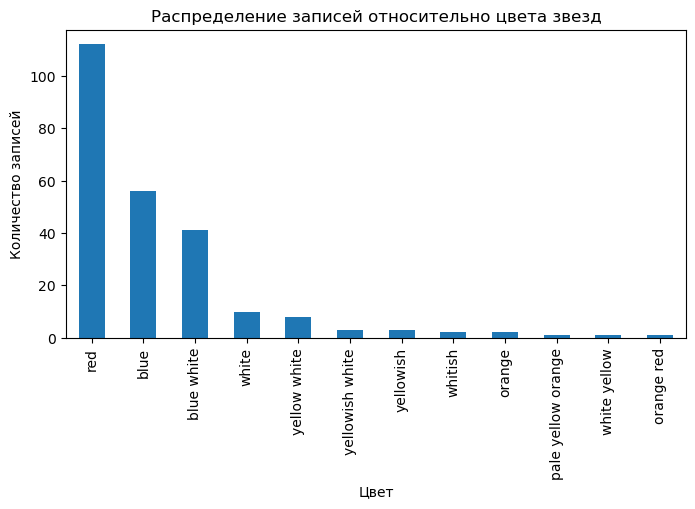

In [13]:
# подсчет количества записей по каждому цвету
fig, ax = plt.subplots(figsize=(8, 4)) 
df['color'].value_counts().plot(kind='bar', ax=ax)
plt.xlabel('Цвет')
plt.ylabel('Количество записей')
plt.title('Распределение записей относительно цвета звезд')
# отображение графика
plt.show()

<div style="padding: 30px 25px; border: 2px #6495ed solid">
 
Исходя из графика, видно, что количество записей относительно разных цветов распределено неравномерно. Чтобы исправить это, предлагается объединить схожие записи цветов. В рамках этой коррекции, следующие группы цветов будут объединены:

- Желтый (yellow) будет включать:

     - Yellowish white
     - Yellow white
     - Yellowish
     - Pale yellow orange
    
- Белый (white) будет включать:

     - White
     - Whitish
     - White yellow
    
- Оранжевый (orange) будет включать:
    
     - Orange
     - Orange red
    
Такое объединение цветов основано на том, что в названии цветов более доминирующий цвет указывается слева относительно записи. Это позволит учесть близкие оттенки цветов и сгруппировать их в более общие категории для улучшения репрезентативности и удобочитаемости данных.
</div>

In [14]:
# создание словаря
replace_color = {
    "yellowish white": "yellow",
    "yellow white": "yellow",
    "yellowish": "yellow",
    "pale yellow orange": "yellow",
    "whitish": "white",
    "white yellow": "white",
    "orange red": "orange",
}
# укрепление групп
df["color"] = df["color"].replace(replace_color).copy()

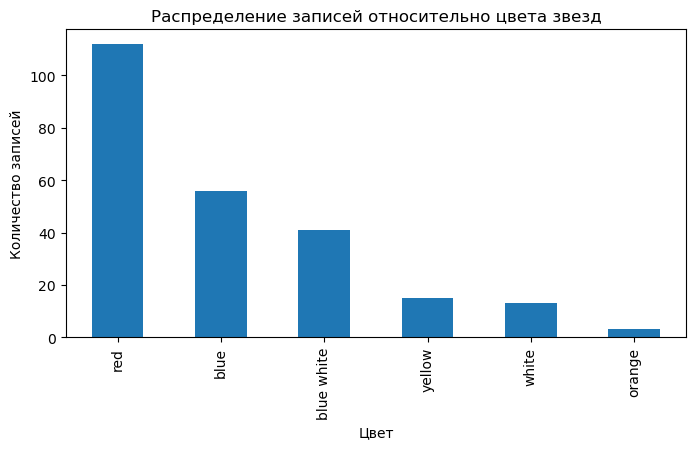

In [15]:
# подсчет количества записей по каждому цвету
fig, ax = plt.subplots(figsize=(8, 4)) 
df['color'].value_counts().plot(kind='bar', ax=ax)
plt.xlabel('Цвет')
plt.ylabel('Количество записей')
plt.title('Распределение записей относительно цвета звезд')
# отображение графика
plt.show()

<div style="padding: 30px 25px; border: 2px #6495ed solid">
    
- Из графика видно, что распределение количества записей стало более сбалансированным после объединения схожих записей цветов. Однако все же остается небольшое количество записей с значением "orange" по сравнению с другими группами цветов. Это важное наблюдение, которое следует учесть при дальнейшем анализе данных.
</div>

<div style="padding:0px 20px 10px; 
            color:#004346;
            font-size:15px;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400"> 

## Анализ числовых признаков
    
</div>

In [16]:
# общая информация
df[['temperature', 'luminosity', 'radius', 'magnitude_abs']].describe().T

,count,mean,std,min,25%,50%,75%,max
temperature,240.0,10497.462500,9552.425037,1939.00000,3344.250000,5776.0000,15055.5000,40000.00
luminosity,240.0,107188.361635,179432.244940,0.00008,0.000865,0.0705,198050.0000,849420.00
radius,240.0,237.157781,517.155763,0.00840,0.102750,0.7625,42.7500,1948.50
magnitude_abs,240.0,4.382396,10.532512,-11.92000,-6.232500,8.3130,13.6975,20.06


- Данные имеют большое стандартное отклонение, что указывает на значительную вариативность.
- Явных аномалий в числовых данных нет.

__Посмотрим на распределения данных__

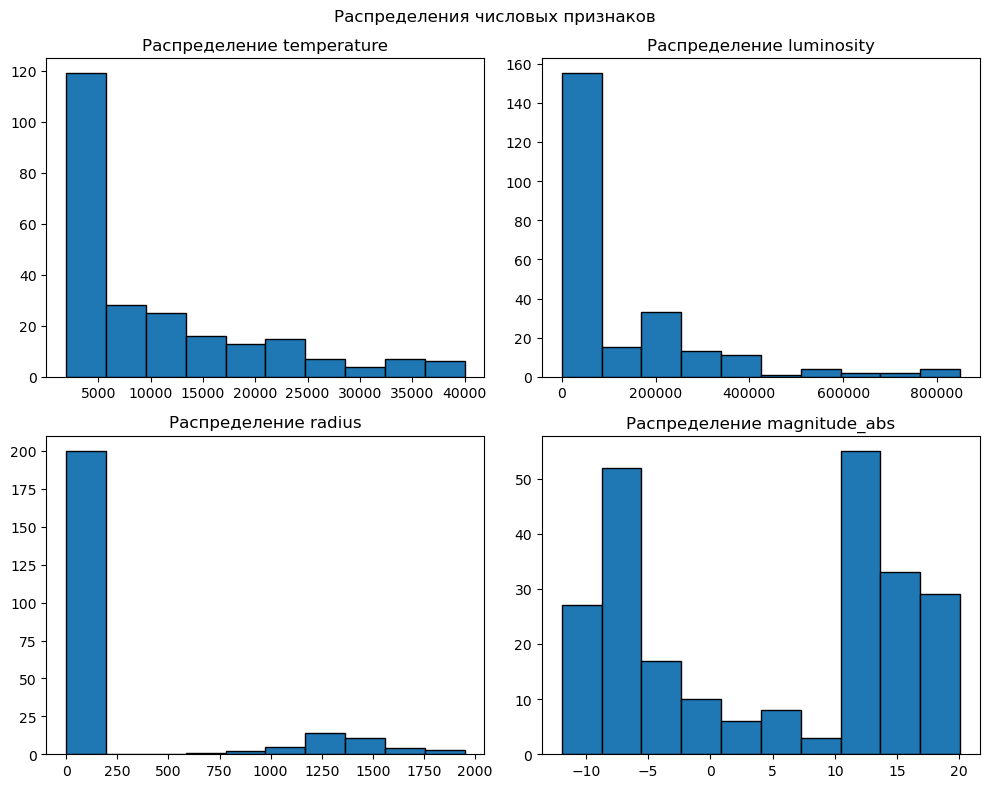

In [17]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8)) 
# гистограмма для 'temperature'
axes[0, 0].hist(df['temperature'], bins=10, edgecolor='black')
axes[0, 0].set_title('Распределение temperature')
# гистограмма для 'luminosity'
axes[0, 1].hist(df['luminosity'], bins=10, edgecolor='black')
axes[0, 1].set_title('Распределение luminosity')
# гистограмма для 'radius'
axes[1, 0].hist(df['radius'], bins=10, edgecolor='black')
axes[1, 0].set_title('Распределение radius')
# гистограмма для 'magnitude_abs'
axes[1, 1].hist(df['magnitude_abs'], bins=10, edgecolor='black')
axes[1, 1].set_title('Распределение magnitude_abs')

plt.suptitle('Распределения числовых признаков')

plt.tight_layout()
plt.show()

<div style="padding: 30px 25px; border: 2px #6495ed solid">
    
- На графиках 'temperature', 'luminosity', 'radius' видно, что распределение ассимитрично вправо, что визуально подтверждает, табличные данные о большом значении стандартного отклонения.
- Так же стоит отметить схожесть графиков, что может быть признаком линейных зависимостей между этими признаками. Таким образом, светимость, возможно, достаточно точно отражает как и энергию звезды, так и ее радиус.
- Абсолютная звёздная величина, график magnitude_abs, имеет симметричное увеличение в обе стороны, что говорит о нисзком количестве схожиж звезд, по данному показателю, среди изученных
</div>

### Корреляции между числовыми признаками

__Линейные взаимосвязи числовых данных__

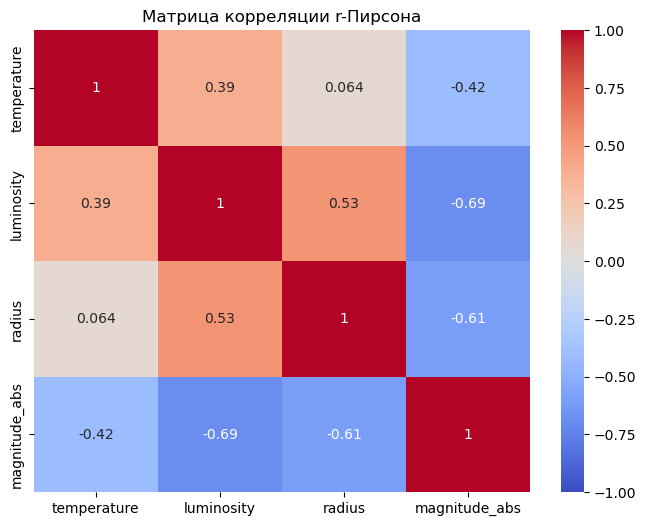

In [18]:
corr_matrix = df[['temperature', 'luminosity', 'radius', 'magnitude_abs']].corr()
# heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Матрица корреляции r-Пирсона')

plt.show()

<div style="padding: 30px 25px; border: 2px #6495ed solid">
    
Предоставленные данные указывают на наличие линейных зависимостей между некоторыми признаками. В частности, обнаружены следующие линейные связи:

- Между температурой и светимостью: Коэффициент корреляции равен 0.39. Это указывает на положительную линейную зависимость между этими двумя признаками. При увеличении температуры возможно увеличение светимости, хотя сила и направление этой зависимости могут быть ограничены.

- Между светимостью и радиусом: Коэффициент корреляции равен 0.53. Это также указывает на положительную линейную зависимость между светимостью и радиусом. Большая светимость может быть связана с более большим радиусом звезды, хотя здесь также могут существовать другие факторы, влияющие на эту зависимость.

Учет этих линейных связей между признаками позволяет лучше понять физические свойства и характеристики звезд. Однако стоит отметить, что линейные связи не всегда являются единственными или полными моделями взаимосвязи между признаками, и возможно наличие иных более сложных взаимосвязей, которые следует учитывать в дальнейшем анализе.
</div>

In [19]:
phik_overview = df[['temperature', 'luminosity', 'radius', 'magnitude_abs']].phik_matrix()
display(phik_overview)

interval columns not set, guessing: ['temperature', 'luminosity', 'radius', 'magnitude_abs']


,temperature,luminosity,radius,magnitude_abs
temperature,1.000000,0.561692,0.236090,0.709280
luminosity,0.561692,1.000000,0.574964,0.709456
radius,0.236090,0.574964,1.000000,0.512414
magnitude_abs,0.709280,0.709456,0.512414,1.000000


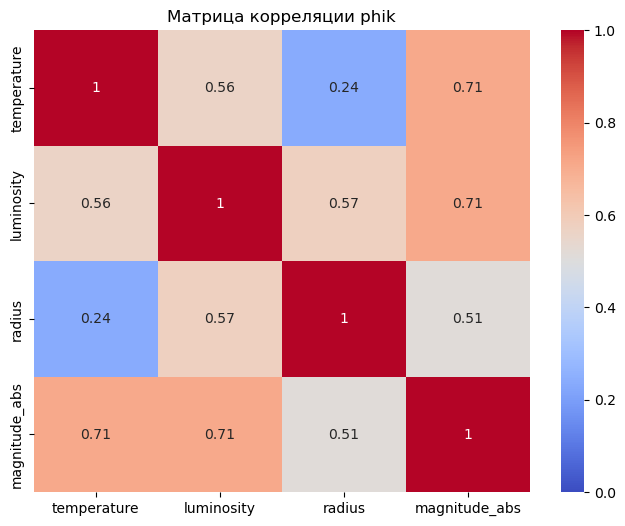

In [20]:
# heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(phik_overview, annot=True, cmap='coolwarm', vmin=0, vmax=1)
plt.title('Матрица корреляции phik')

plt.show()

<div style="padding: 30px 25px; border: 2px #6495ed solid">

Согласно предоставленным данным, наблюдаются сильные нелинейные взаимосвязи между различными признаками, такими как температура, светимость, радиус и абсолютная величина звезд.

Присутствие таких нелинейных взаимосвязей подтверждает потенциал использования алгоритмов нейросетей для определения температуры на поверхности обнаруженных звезд. Нейронные сети могут эффективно обнаруживать и моделировать сложные нелинейные взаимосвязи в данных и строить предсказательные модели, которые учитывают эти взаимосвязи. Это позволяет получить более точные и надежные прогнозы температуры на основе других характеристик звезды.

Однако важно отметить, что выбор и конфигурация алгоритмов нейросетей требует тщательного исследования, обучения и оптимизации. Это поможет достичь наилучших результатов и гарантировать, что модель нейросети адекватно учитывает нелинейные взаимосвязи в данных для определения температуры на поверхности звезд.
</div>

<div style="padding:0px 20px 10px; 
            color:#004346;
            font-size:15px;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400"> 

# Подготовка данных к построению модели
    
</div>

- Разделение данных: Разделим данные на тренировочную и тестовую выборки. Поскольку у вас ограниченное количество наблюдений, оставить 20% данных для тестирования модели, а остальные 80% используем для обучения модели.
- Нормализация числовых данных: Произведем нормализацию числовых данных, чтобы все признаки имели сопоставимые диапазоны значений. Нормализация поможет стабилизировать обучение модели и предотвратить преимущественное влияние признаков с большими значениями.
- Преобразование категориальных данных в унитарный код: Категориальные данные, такие как цвет или тип звезды, необходимо преобразовать в унитарный код (one-hot encoding). Это позволит представить каждое категориальное значение в виде бинарного вектора, где каждый столбец соответствует определенной категории. Такое представление позволит модели учиться на категориальных данных.

## Выделение обучающей и тестовой выборок

In [21]:
X = df.drop('temperature', axis=1)
y = df['temperature'] # целевой признак

In [22]:
# формирование выборок
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [23]:
# проверка размерности выборок
for x in ['X_train', 'X_test', 'y_train', 'y_test']:
    print(f'Размерность {x}: {globals()[x].shape} - {len(globals()[x])/len(df):.0%}')

Размерность X_train: (192, 5) - 80%
Размерность X_test: (48, 5) - 20%
Размерность y_train: (192,) - 80%
Размерность y_test: (48,) - 20%


## Нормализация входных данных

In [24]:
categorical_columns = ["type", "color"]
numeric_columns = ["luminosity", "radius", "magnitude_abs"]

col_transformer = ColumnTransformer(
    transformers=[
        ("scaler", StandardScaler(), numeric_columns), # преобразование числовых данных
        ("ohe", OneHotEncoder(sparse_output=False), categorical_columns), # преобразование категориальных данных
    ],
    remainder="passthrough",
    n_jobs=-1
)
# преобразование данных
X_train = col_transformer.fit_transform(X_train)
X_test = col_transformer.transform(X_test)

## Создание тензеров

In [27]:
# преобразование выборок в тензоры
X_train_tensor = torch.Tensor(X_train)
X_test_tensor = torch.Tensor(X_test)
y_train_tensor = torch.Tensor(y_train.values)
y_test_tensor = torch.Tensor(y_test.values)
# проверка размерности тензоров
for x in ['X_train_tensor', 'X_test_tensor', 'y_train_tensor', 'y_test_tensor']:
    print(f'Размерность {x}: {globals()[x].shape}')

Размерность X_train_tensor: torch.Size([192, 15])
Размерность X_test_tensor: torch.Size([48, 15])
Размерность y_train_tensor: torch.Size([192])
Размерность y_test_tensor: torch.Size([48])


<div style="padding:0px 20px 10px; 
            color:#004346;
            font-size:15px;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400"> 

# Построение простой модели нейронной сети — baseline
    
</div>

__Архитектура нейронной сети:__

1 Входной слой:

   - Размерность входных данных определяется переменной input_size и равен количеству признаков.
   - Этот слой представлен в виде линейного слоя (nn.Linear), который принимает входные данные и производит линейную трансформацию с помощью весов и смещения.
   
2 Скрытые слои:

   - В данной архитектуре нейронной сети используем три скрытых слоя.
   - Каждый скрытый слой состоит из линейного слоя (nn.Linear), за которым следует функция активации.
   - Функции активации, используемые в этой архитектуре, включают ReLU (nn.ReLU()), гиперболический тангенс (nn.Tanh()) и LeakyReLU (nn.LeakyReLU()).
   - Размеры скрытого слоя определяются переменными hidden_size_1, hidden_size_2, hidden_size_3, hidden_size_4.
   
3 Выходной слой:

   - Выходной слой представлен линейным слоем (nn.Linear), который преобразует выходные значения скрытых слоев в одно число.
   - В данном случае, поскольку решается задача регрессии, выходной слой имеет размерность 1 и задается переменной output_size.

In [562]:
# определение архитектуры нейронной сети
class Net(nn.Module):
    def __init__(self, input_size, hidden_size_1, hidden_size_2, hidden_size_3, output_size):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size_1)
        self.activation1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size_1, hidden_size_2)
        self.activation2 = nn.Tanh()
        self.fc3 = nn.Linear(hidden_size_2, hidden_size_3)
        self.activation3 = nn.ReLU()
        self.fc4 = nn.Linear(hidden_size_3, hidden_size_4)
        self.activation4 = nn.LeakyReLU()
        self.fc5 = nn.Linear(hidden_size_4, output_size)
        
    def forward(self, x):
        x = self.activation1(self.fc1(x))
        x = self.activation2(self.fc2(x))
        x = self.activation3(self.fc3(x))
        x = self.activation4(self.fc4(x))
        x = self.fc5(x)
        return x

In [563]:
# параметры нейронной сети
input_size = X_train_tensor.shape[1]  # размер входных данных
hidden_size_1 = 50  # размер 1-го скрытого слоя
hidden_size_2 = 40  # размер 2-го скрытого слоя
hidden_size_3 = 5  # размер 3-го скрытого слоя
hidden_size_4 = 45  # размер 4-го скрытого слоя
output_size = 1     # размер выходного слоя
learning_rate = 0.01  # скорость обучения

num_epochs = 100  # количество эпох обучения
batch_size = 32  # размер пакета

In [564]:
# экземпляр нейронной сети
model = Net(input_size, hidden_size_1, hidden_size_2, hidden_size_3, output_size)
# функция потерь
criterion = nn.MSELoss()
# оптимизатор
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [565]:
# обучение
for epoch in range(num_epochs):
    running_loss = 0.0
    for i in range(0, X_train_tensor.shape[0], batch_size):
        inputs = X_train_tensor[i:i+batch_size]
        labels = y_train_tensor[i:i+batch_size]

        optimizer.zero_grad()

        outputs = model(inputs)
        labels = labels.unsqueeze(1) 
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    epoch_loss = running_loss / (X_train_tensor.shape[0] // batch_size)
    # вывод результатов каждой десятой и последней эпох:
    if epoch % 10 == 0 or epoch == num_epochs - 1:
        print(f"Epoch {epoch} loss: {round(epoch_loss)} RMSE: {round(sqrt(epoch_loss))}")

Epoch 0 loss: 193168041 RMSE: 13898
Epoch 10 loss: 174031408 RMSE: 13192
Epoch 20 loss: 87733273 RMSE: 9367
Epoch 30 loss: 59343635 RMSE: 7703
Epoch 40 loss: 27251126 RMSE: 5220
Epoch 50 loss: 19750865 RMSE: 4444
Epoch 60 loss: 20099129 RMSE: 4483
Epoch 70 loss: 19208952 RMSE: 4383
Epoch 80 loss: 19184698 RMSE: 4380
Epoch 90 loss: 19100066 RMSE: 4370
Epoch 99 loss: 19030055 RMSE: 4362


<div class="alert alert-success">
<b>Комментарий ревьюера ✔️:</b>

Да, хорошо, либо можно сгладить выход, так как сейчас модель возвращает `[[0], [1]]`, а нужно `[0, 1]` 
    
В `PyTorch` параметр `start_dim` в методе `flatten()` указывает на размерность тензора, начиная с которой происходит сглаживание `(flatten)`.

При использовании `start_dim=0`, весь тензор будет сглажен в одномерный вектор, начиная с первого элемента. Если указать `start_dim=1`, то первый элемент тензора останется без изменения, а остальные элементы будут сглажены. Если start_dim=2, то первые две размерности тензора останутся без изменения, а все остальные размерности будут сглажены в одномерный вектор. И так далее.

    
Поэтому получаем:    
   
```python
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()  
        self.fc1= nn.Linear(in_neurons,n_hidden_neurons)
        self.fc2= nn.Linear(n_hidden_neurons,n_oout_neurons)
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten(start_dim=0)
    def forward(self,x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        return self.flatten(x)        
```

---------------
    
    
Можно еще отключить вычисление градиентов```with torch.no_grad()```:
    
```python
    for epoch in range(num_epochs):
        model.train()
        <your code>
        if epoch % 1000 == 0:
            with torch.no_grad():
                model.eval()
                <your code>
```

Чтобы не подбирать кол-во эпох, можно воспользоваться EarlyStopping:
                
+  https://debuggercafe.com/using-learning-rate-scheduler-and-early-stopping-with-pytorch/
          
                
P.S Еще бы произвести визуализацию обучения, чтобы можно было убедиться: а дообучили ли мы модель или у нас переобучение  


</div>


In [566]:
# проверка на тестовых данных
with torch.no_grad():
    y_pred_tensor = model(X_test_tensor)
    y_pred = y_pred_tensor.numpy().flatten()
    rmse = sqrt(mean_squared_error(y_test_tensor, y_pred))
    print(f'RMSE на тестовых данных: {round(rmse)}')

RMSE на тестовых данных: 5778


__Визуализация результатов:__

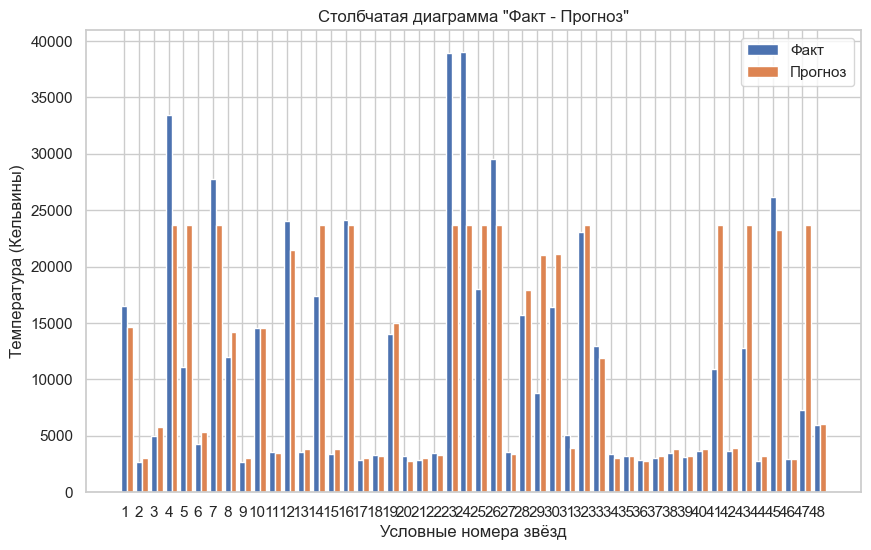

In [567]:
actual_values = y_test_tensor.numpy().flatten()
predicted_values = y_pred_tensor.numpy().flatten()
# условные номера звезд
star_numbers = range(1, len(actual_values) + 1)

bar_width = 0.4 # ширина столбцов

plt.figure(figsize=(10, 6))
plt.bar(star_numbers, actual_values, width=bar_width, label='Факт', align='center')
plt.bar(np.array(star_numbers) + bar_width, predicted_values, width=bar_width, label='Прогноз', align='center')
plt.xlabel('Условные номера звёзд')
plt.ylabel('Температура (Кельвины)')
plt.title('Столбчатая диаграмма "Факт - Прогноз"')
plt.legend()
plt.grid(True)
plt.xticks(star_numbers)
plt.show()

<div style="padding: 30px 25px; border: 2px #6495ed solid">
    
    - Метрика качества простой модели нейронной сети на тестовых данных составила 5778, что ниже заявленного минимума.
    - По графику "Факт - Прогноз" видно, что модель прохо предсказывает температуру наиболее горячих звезд, давая более усредненные значение.
    - Одной из очивидных причин этого следует отметить, низкое количечество записей.
    - В дальшейшем попробуем усовершенствовать алгоритм, подбором параметров, таких как размер пакета обучения, использование метода «dropout» и др.
    
</div>

 <div class="alert alert-success">
<b>Комментарий ревьюера ✔️:</b> Хорошо
</div>
            
            
            

<div style="padding:0px 20px 10px; 
            color:#004346;
            font-size:15px;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400"> 

# Улучшение нейронной сети
    
</div>

- Добавим технику регуляризации Dropout, которая поможет улучшить обобщающую способность нейронной сети и снизит риск переобучения.
- Используем подбор значений Dropout и размера пакета обучения
- В процессе подбора сохраним наилучшую модель и ее предсказание, для дальнейшей визуализации.

In [556]:
# архитектура нейронной сети
class Net(nn.Module):
    def __init__(self, input_size, hidden_size_1, hidden_size_2, hidden_size_25, hidden_size_3, output_size, dropout_prob):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size_1)
        self.activation1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout_prob)
        self.fc2 = nn.Linear(hidden_size_1, hidden_size_2)
        self.activation2 = nn.Tanh()
        self.fc3 = nn.Linear(hidden_size_2, hidden_size_3)
        self.activation3 = nn.ReLU()
        self.fc4 = nn.Linear(hidden_size_3, hidden_size_4)
        self.activation4 = nn.LeakyReLU()
        self.fc5 = nn.Linear(hidden_size_4, output_size)

    def forward(self, x):
        x = self.activation1(self.fc1(x))
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.activation2(x)
        x = self.activation3(self.fc3(x))
        x = self.activation4(self.fc4(x))
        x = self.fc5(x)
        return x

In [557]:
# параметры нейронной сети
input_size = X_train_tensor.shape[1]  # размер входных данных
hidden_size_1 = 50  # размер 1-го скрытого слоя
hidden_size_2 = 40  # размер 2-го скрытого слоя
hidden_size_3 = 5  # размер 3-го скрытого слоя
hidden_size_4 = 45  # размер 4-го скрытого слоя
output_size = 1     # размер выходного слоя
learning_rate = 0.01  # скорость обучения
num_epochs = 100  # количество эпох обучения
# значения для dropout и размера батча
param_grid = {
    'dropout': [0.1, 0.2, 0.3, 0.4, 0.5],
    'batch_size': [8, 16, 32, 64, 128]
}

In [558]:
# переменные для сохранения лучших показателей
best_rmse = float('inf')
best_params = {}
best_model = None
best_predict = None
# возможные комбинации параметров
parameter_combinations = ParameterGrid(param_grid)

In [559]:
# цикл по комбинациям параметров
for params in parameter_combinations:
    dropout = params['dropout']
    batch_size = params['batch_size']

    # экземпляра нейросети с текущими значениями dropout и размера батча
    model = Net(input_size, hidden_size_1, hidden_size_2, hidden_size_3, hidden_size_4, output_size, dropout_prob=dropout)
    # определение функции потерь и оптимизатора
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    # обучение и оценка модели с новыми значениями dropout и размера батча
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i in range(0, X_train_tensor.shape[0], batch_size):
            inputs = X_train_tensor[i:i+batch_size]
            labels = y_train_tensor[i:i+batch_size]

            optimizer.zero_grad()

            outputs = model(inputs)
            labels = labels.unsqueeze(1) 
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        epoch_loss = running_loss / (X_train_tensor.shape[0] // batch_size)

    # оценка модели на тестовых данных
    with torch.no_grad():
        y_pred_tensor = model(X_test_tensor)
        y_pred = y_pred_tensor.numpy().flatten()
        rmse = sqrt(mean_squared_error(y_test_tensor, y_pred))

    # вывод результатов для текущей комбинации параметров
    print(f"Dropout: {dropout}, Batch Size: {batch_size}, RMSE: {rmse}")

    # обновление наилучших результатов, если получен более лучший RMSE
    if rmse < best_rmse:
        best_rmse = rmse
        best_params = {'dropout': dropout, 'batch_size': batch_size}
        best_model = model
        best_predict = y_pred

Dropout: 0.1, Batch Size: 8, RMSE: 4871.904555715352
Dropout: 0.2, Batch Size: 8, RMSE: 4820.00311203219
Dropout: 0.3, Batch Size: 8, RMSE: 4617.015486220509
Dropout: 0.4, Batch Size: 8, RMSE: 4680.181406740555
Dropout: 0.5, Batch Size: 8, RMSE: 4388.817380570761
Dropout: 0.1, Batch Size: 16, RMSE: 5206.435248805078
Dropout: 0.2, Batch Size: 16, RMSE: 5831.310315872412
Dropout: 0.3, Batch Size: 16, RMSE: 4640.953565809509
Dropout: 0.4, Batch Size: 16, RMSE: 4863.979646338994
Dropout: 0.5, Batch Size: 16, RMSE: 5175.0996125678585
Dropout: 0.1, Batch Size: 32, RMSE: 5762.0281151691715
Dropout: 0.2, Batch Size: 32, RMSE: 4949.4524949735605
Dropout: 0.3, Batch Size: 32, RMSE: 4709.9188952677305
Dropout: 0.4, Batch Size: 32, RMSE: 4815.305597778816
Dropout: 0.5, Batch Size: 32, RMSE: 4958.858941329144
Dropout: 0.1, Batch Size: 64, RMSE: 5711.049640827858
Dropout: 0.2, Batch Size: 64, RMSE: 5086.253434503633
Dropout: 0.3, Batch Size: 64, RMSE: 4957.541326101074
Dropout: 0.4, Batch Size: 64, 

In [561]:
# вывод наилучшего результата
print(f"Best RMSE: {best_rmse}")
print(f"Best Parameters: {best_params}")

Best RMSE: 4388.817380570761
Best Parameters: {'dropout': 0.5, 'batch_size': 8}


 <div class="alert alert-success">
<b>Комментарий ревьюера ✔️:</b> Отлично, получился шикарный результат
</div>
            
            
            

 <div class="alert alert-success">
<b>Комментарий ревьюера ✔️:</b> Для подбора еще можно воспользоваться библиотекой scorch
    
Для начала напишем нейросеть:
    
    
```python
    class Model_improve(nn.Module):
    def __init__(self, n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_hidden_neurons_3, n_out_neurons, 
                 dropout_1, dropout_2,  dropout_3, activation_1, activation_2):
        super(Model_improve, self).__init__()
        
        <your code>

    def forward(self, x):
        <your code>
        return x

```

    
Вот так можно использовать skorch:) Смотри тут можно применить EarlyStopping:

```python
   from skorch.callbacks import EpochScoring, EarlyStopping
   skorch_regressor = NeuralNetRegressor(module=model_base, 
                                      device='cpu',  
                                      verbose=3,
                                      batch_size=batch_size,
                                      optimizer=torch.optim.Adam, 
                                      max_epochs=2500, 
                                      lr=lr,
                                      train_split=ValidSplit(cv=5),
                                      criterion =nn.MSELoss,
                                      callbacks=[
                ('val_rmse', EpochScoring(scoring=rmse_scorer, lower_is_better=True, name='RMSE')),
                ('estoper', EarlyStopping( lower_is_better=True, monitor='RMSE', patience=patience)),
            ],
                                     ) 
    
```
Осталось разобраться и подставить нужные значения в пропущенные места:)
            
```model_base``` - твоя нейросеть - ```net = Model_improve(<your code>)```
    
    
P.S rmse_scorer можно определить через ```make_scorer```    

    
Задать параметры можно вот так:    
```python
    params = {
    'module__dropout': [0, 0.1],
    'module__n_hidden_neurons_1': range(10, 30, 5),
    'module__n_hidden_neurons_2': range(10, 30, 5),
    'module__activation': [nn.LeakyReLU(), nn.Tanh(), nn.ReLU(), nn.ELU()],
    'lr': [1e-3, 1e-4]
}
```
Обрати внимание, что это только пример!!! его еще необходимо настроить под себя. Чтобы обратиться к параметрам нейросети используй ```module__```, если просто к NeuralNetRegressor, то без приставки:)
    
Подбор паарметров:
    
    
```python
    grid = RandomizedSearchCV(skorch_regressor, params, cv=3, scoring="neg_root_mean_squared_error", verbose=3) 
    grid.fit(X_train_tensor, y_train_tensor.reshape(-1,1)) 
    
    
```
</div>
            
            
            

__Визуализация результатов:__

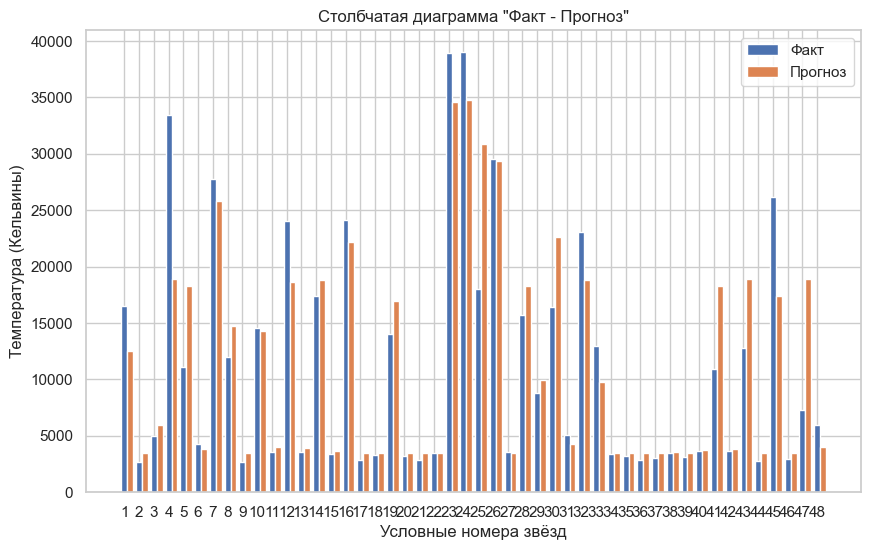

In [568]:
actual_values = y_test_tensor.numpy().flatten()
predicted_values = best_predict
# условные номера звезд
star_numbers = range(1, len(actual_values) + 1)

bar_width = 0.4 # ширина столбцов

plt.figure(figsize=(10, 6))
plt.bar(star_numbers, actual_values, width=bar_width, label='Факт', align='center')
plt.bar(np.array(star_numbers) + bar_width, predicted_values, width=bar_width, label='Прогноз', align='center')
plt.xlabel('Условные номера звёзд')
plt.ylabel('Температура (Кельвины)')
plt.title('Столбчатая диаграмма "Факт - Прогноз"')
plt.legend()
plt.grid(True)
plt.xticks(star_numbers)
plt.show()

<div style="padding: 30px 25px; border: 2px #6495ed solid">
    
    - Метрика качества модели после применения подбора параметров нейронной сети, на тестовых данных составила 4389, что соответствует заявленному минимуму.
    - По графику "Факт - Прогноз" видно, что модель стала лучше предсказывать температуру наиболее горячих звезд, по сравнению с простой моделью.
    - Оптимальные параметры:
        - 'dropout': 0.5
        - 'batch_size': 8
    
</div>

<div style="padding:0px 20px 10px; 
            color:#004346;
            font-size:15px;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400"> 

# Вывод
    
</div>

- Проведен анализ и предобработка данных.
- Разработаны и проверены на данных для тестирования две нейронные сети.
- Достигнута удовлетворяющая метрика качества (4389).
- Во второй модели проведен подбор параметров размера пакета (батча) и Dropout, без изменений в архитектуре сети:

   - Оптимальный размера пакета (батча) составил 8, что ниже по сравнению размера батча в исходной модели, что имеет плюсы:
       - Ускорение обучения: Уменьшение размера пакета позволяет обновлять веса модели чаще, поскольку каждая эпоха будет иметь больше итераций. Это может привести к ускорению процесса обучения и быстрому сходимости модели.

       - Экономия памяти: Меньший размер пакета требует меньше оперативной памяти для хранения активаций и градиентов.

       - Более стабильное обновление весов: Уменьшение размера пакета может сделать обновление весов более стабильным и надежным, поскольку каждое обновление основано на меньшем числе образцов данных. Это может помочь предотвратить большие колебания в процессе обучения и повысить стабильность модели.
       
   - Преимущества применения метода Dropout:

        - Dropout помогает уменьшить взаимозависимость между нейронами в сети, поскольку каждый нейрон может быть случайным образом отключен. Это позволяет модели изучать более разнообразные представления данных и уменьшает риск сильной корреляции между нейронами.

        - Модель становится более устойчивой к шуму в данных. Это может помочь улучшить обобщающую способность модели, то есть ее способность делать точные прогнозы на новых, неизвестных данных.
 __________       
- __Рекомендации:__
     - Необходим сбор дополнительных данных, что позволит построить модель с большей точностью прогнизирования.

<div class="alert alert-success">
<b>Комментарий ревьюера ✔️:</b>
    
Немного полезного материала:    

1) Ребята из-за "бугра": https://www.reg.ru/blog/stenfordskij-kurs-lekciya-1-vvedenie/ (тут про свёрточные, но интересно)<br>
2) Интересная статья специалиста Тесла: https://karpathy.github.io/neuralnets/ <br>
3) Список книг на выбор: https://habr.com/ru/company/neurodatalab/blog/336218/ <br>



Кстати есть еще нейросеть TabNet, которая заточена для работы с табличными данными:
+  https://habr.com/ru/post/540736/    
+  https://www.kaggle.com/code/carlmcbrideellis/tabnet-a-very-simple-regression-example/notebook

</div>

<div class="alert alert-success">
<b>Комментарий ревьюера ✔️:</b> 
    
Еще можно было вот так решить:
    
+  https://colab.research.google.com/drive/1ZyMsfYf5c1jzBurRKMIlF8n6Vmn7Lpad?usp=sharing

</div>


<font color='blue'><b>Итоговый комментарий ревьюера</b></font>
<div class="alert alert-success">
<b>Комментарий ревьюера ✔️:</b>Денис, спасибо за хороший проект!!! Я готов принять работу, но хочу убедиться, что тебе все понятно.<br>
Если есть какие либо вопросы я с удовольствием на них отвечу:)</div>
